# Step 1: Network Filtering and Processing
---
### This the first of five steps to running BikewaySim
1. __Process network spatial data into a routable network graph format__
2. Reconcile networks into one through node and link overlap conflation
3. Create final network graph and calculate link costs
4. Create OD tables
5. Run BikewaySim

Run this code block by block to convert a road network shapefile in ESRI Shapefile, GeoJSON, or GeoPackage format into a routable and conflated network graph to use in BikewaySim.

Note that three networks were used in this project. While code to obtain OSM GeoJSONs has been included with osm_processing notebook, the ABM and HERE networks need to be sourced from the Atlanta Regional Commission and HERE respectively. You can run most of this code with only OSM data, but you can skip Step 2.

#### Import/install the following packages:

In [1]:
from pathlib import Path
import geopandas as gpd

#### Import Network Filter Module:

In [2]:
from network_filter import *

#### General Settings Dictionary

In [3]:
#use this if all the files are in the same directory
working_dir = Path.home() / Path('Documents/NewBikewaySimData')

settings = {
    'output_fp': working_dir, #where filtered network files will output
    'crs': "EPSG:2240", # project all spatial data to this CRS
    'studyarea_fp': working_dir / Path('Data/Study Areas/bikewaysim_studyarea.geojson'),
    'studyarea_name': 'bikewaysim',
    'studyarea_layer': None, #replace with study area layer name if file is gpkg or gdb
    'use_bbox': False # use bounding box instead of studyarea polygon boundaries as mask for importing links
}

#other filepaths
#studyareafp = r'base_shapefiles/studyareas/atl_district5.gpkg'
#studyarea_name = 'atl_district5'
#studyareafp = r'base_shapefiles/studyareas/ITS4US_StudyBoundary.shp'
#studyarea_name = 'its4us'
#studyareafp = r'base_shapefiles/studyareas/district5.geojson'
#studyarea_name = 'district5'
#studyareafp = r'base_shapefiles/studyareas/marta.gpkg'
#studyarea_name = 'marta'

#### Import study area:
Specify what area you want to mask the network data by. Only network links that are partially or fully within the study area will be imported. Note: network links are NOT clipped (because this cuts off nodes).

The area of the bikewaysim study area is 12.26 square miles.


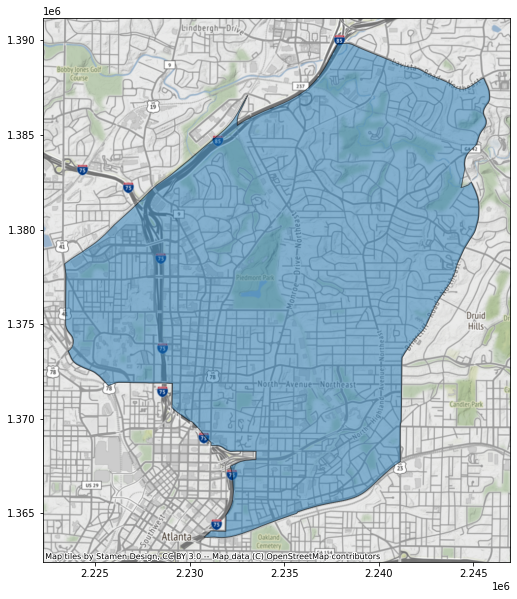

In [4]:
settings['studyarea'] = import_study_area(settings)

## Run Network Filter Module to Create Initial Subnetworks
From the network_filter.py file run the filter networks function. This will first import the spatial data and then filter the data into a base, road, bike, or serivce link. 
**Note: If this is the a new network that is not OSM, HERE, or ABM then specify a new filter method by going into the network_filter.py file.** Otherwise, none of the links will be filtered into road/bike/service links. **Also note: all spatial files are being projected to EPSG 2240 right now.** Need to modify later.

## OpenStreetMap (OSM) Filtering
OSM is an open-source mapping project (see www.openstreetmap.org)

OSM network data can be downloaded using the "osm_processing.ipynb" Jupyter Notebook.

In [5]:
studyarea_name = settings['studyarea_name']
osmfp = working_dir / Path(f'Data/osm/{studyarea_name}.gpkg')

osm = {
       "network_name": 'osm',
       "links_fp": osmfp, 
       "links_layer":"links", 
       "nodes_fp":osmfp, 
       "nodes_layer":"nodes",
       "nodes_id": "osmid",
       "A": "A",
       "B": "B"
       }

filter_networks(settings,osm)

Filtering the osm network.
There is a nodes layer...
and links and nodes have reference ids.
Cleaning measures applied for osm...
osm roadbike filter applied...
osm road filter applied...
osm bike filter applied...
osm service filter applied...
osm imported... took 0.27 minutes


# HERE Filtering

In [6]:
herefp = working_dir / Path('Data/HERE/Streets.shp')

here = {
       "network_name": 'here', # name for network
       "links_fp": herefp, #filepath for the links
       "links_layer":None, # layer name for links if gpkg or gdb
       "nodes_fp": None, # if there is not a nodes file put None
       "nodes_layer": None, # layer name for nodes if gpkg or gdb (put none if no nodes)
       "nodes_id": None, # column name of node id (put none if no node id)
       "A": "REF_IN_ID", # starting node id reference column on links (put none if no reference links)
       "B": "NREF_IN_ID" # starting node id reference column on links (put none if no reference links)
       }

filter_networks(settings,here)

Filtering the here network.
no nodes layer
but links have reference ids


c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


here roadbike filter applied...
here road filter applied...
here bike filter applied...
here service filter applied...
here imported... took 0.49 minutes


# ABM Filtering

In [7]:
abmfp = working_dir / Path('Data/ARC/rtp_amd6_2030_network.gdb')

abm = {
       "network_name": 'abm',
       "links_fp": abmfp,
       "links_layer":"DAILY_Link",
       "nodes_fp":abmfp,
       "nodes_layer":"DAILY_Node",
       "nodes_id": "N",
       "A": "A",
       "B": "B"
       }

filter_networks(settings,abm)

Filtering the abm network.
There is a nodes layer...
and links and nodes have reference ids.
Cleaning measures applied for abm...


c:\Users\tpassmore6\Documents\GitHub\BikewaySimDev\network_filter.py:168: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  links = links.explode().reset_index(drop=True)


No further filter needed for abm
No further filter needed for abm
No bike links present for abm
No service links present for abm
abm imported... took 0.12 minutes


If your network file has layers, you can use this code snippet to print them out:

In [8]:
import fiona
fiona.listlayers(osmfp)

['nodes', 'links']

## Summurize filtered networks
#### Prints out:
- Number of nodes
- Number of links
- Total length of all links
- Average link length

#### Exports:
- CSV file with all the network statistics.

In [9]:
#summurize networks and export summary as "network_summary.csv in the working directory
summary(settings)

                    num_links num_nodes tot_link_length avg_link_length
osm_links_raw           25087     18401           608.0           127.9
osm_links_general       18129     15597           416.0           121.2
osm_links_roadbike      10582      9407           276.0           137.8
osm_links_road           7000      6192           212.0           160.1
osm_links_bike           3582      3456            64.0            94.3
osm_links_service        7558      8713           140.0            97.9
here_links_raw          11954      9307           396.0           175.0
here_links_general      11676      9064           375.0           169.4
here_links_roadbike      5406      4633           220.0           215.1
here_links_road          5397      4627           220.0           215.2
here_links_bike          2011      1779            46.0           122.0
here_links_service       4268      4582           108.0           133.8
abm_links_raw            2613      2121           194.0         